<a href="https://colab.research.google.com/github/eldorjonneymatov/air_passenger_satisfaction/blob/master/airline_passenger_satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aviakompaniya yo'lovchilarining qoniqishi 

## Faoliyatni o\`rganish 

**Loyiha maqsadi**: Amerika Qo'shma Shtatlaridagi parvozlarga nisbatan yo'lovchilarning fikri haqida berilgan ma'lumotlarga asosan yo'lovchilarning qoniqishlarini bashorat qiladigan model yaratish.

## Kerakli modullarni yuklab olish va vizualizatsiya uchun ba\`zi parametrlarni o\`rnatish 

In [ ]:
!pip install opendatasets
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import opendatasets as od
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from fastai.vision.all import *

In [ ]:
backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [4, 4]
sns.set_style('darkgrid')

## Ma\`lumotlar bilan tanishish 

In [ ]:
od.download('https://www.kaggle.com/competitions/aviakompaniya/data')

100%|██████████| 244k/244k [00:00<00:00, 54.0MB/s]


Extracting archive ./aviakompaniya/aviakompaniya.zip to ./aviakompaniya


In [ ]:
os.listdir('./aviakompaniya')

['sample_submission.csv', 'train_dataset.csv', 'test_dataset.csv']

In [ ]:
data = pd.read_csv('aviakompaniya/train_dataset.csv')
df = data.copy(deep=True)
df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0
1,2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,...,5,5,5,5,3,5,3,0,0.0,1
2,3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,...,4,5,2,5,3,5,4,0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,...,4,4,1,4,4,4,3,21,12.0,0
9996,9997,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,...,4,4,4,4,1,4,4,34,21.0,0
9997,9998,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,...,4,4,4,4,3,4,3,37,38.0,1
9998,9999,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,...,3,4,5,5,5,4,5,64,210.0,1


Yo\`lovchi ma\`lumotlariga aloqador bo\`lmagan `id` ustunini olib tashlaymiz 

In [ ]:
class DropUnnecessaryFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features=['id']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                X.drop(f, axis=1, inplace=True)
        return X
drop_features = DropUnnecessaryFeatures()
drop_features.fit_transform(df);

### Ustunlar tavsifi
* `Gender`: yo'lovchilarning jinsi (ayol, erkak)
* `Customer Type`: mijoz turi (sodiq mijoz, ishonchsiz mijoz)
* `Age`: yo'lovchilarning haqiqiy yoshi
* `Type of Travel`: yo'lovchilar parvozining maqsadi (shaxsiy sayohat, biznes sayohat)
* `Class`: yo'lovchilar samolyotida sayohat klassi (Business, Eco, Eco Plus)
* `Flight distance`: Ushbu sayohatning parvoz masofasi
* `Inflight wifi service`: Parvoz ichidagi Wi-Fi xizmatidan qoniqish darajasi (0: Tegishli emas; 1-5)
* `Departure/Arrival time convenient`: Ketish/Kelish vaqtining qoniqish darajasi
* `Ease of Online booking`: Onlayn bron qilishdan qoniqish darajasi
* `Gate location`: Darvoza joylashuvidan qoniqish darajasi
* `Food and drink`: Oziq-ovqat va ichimlikdan qoniqish darajasi
* `Online boarding`: Onlayn bortdan qoniqish darajasi
* `Seat comfort`: O'rindiqning qulayligidan qoniqish darajasi
* `Inflight entertainment`: Parvoz ichidagi o'yin-kulgidan qoniqish darajasi
* `On-board service`: Bort xizmatidan qoniqish darajasi
* `Leg room service`: oyoq xonasi xizmatidan qoniqish darajasi
* `Baggage handling`: bagajni tashishdan qoniqish darajasi
* `Check-in service`: Ro'yxatdan o'tish xizmatidan qoniqish darajasi
* `Inflight service`: Parvoz ichidagi xizmatdan qoniqish darajasi
* `Cleanliness`: Tozalikdan qoniqish darajasi
* `Departure Delay in Minutes`: jo‘nash vaqtida kechikish daqiqalari
* `Arrival Delay in Minutes`: yetib kelganda kechikish daqiqalari
* `Satisfaction`: Aviakompaniyaning qoniqish darajasi (qoniqish, neytral yoki norozilik)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             10000 non-null  object 
 1   Customer Type                      10000 non-null  object 
 2   Age                                10000 non-null  int64  
 3   Type of Travel                     10000 non-null  object 
 4   Class                              10000 non-null  object 
 5   Flight Distance                    10000 non-null  int64  
 6   Inflight wifi service              10000 non-null  int64  
 7   Departure/Arrival time convenient  10000 non-null  int64  
 8   Ease of Online booking             10000 non-null  int64  
 9   Gate location                      10000 non-null  int64  
 10  Food and drink                     10000 non-null  int64  
 11  Online boarding                    10000 non-null  int6

`Arrival Delay in Minutes` ustunida 28 ta **Nan** qiymatlar bor ekan. Ularni 0 qiymat bilan to\`ldiramiz.

In [ ]:
class FillMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, value=0):
        self.value = value
    def fit(self, X):
        return self
    def transform(self, X):
        X = X.fillna(self.value)
        return X
fill_missing = FillMissingValues()
fill_missing.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,4,3,1,3,4,3,4,10,3.0,0
1,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,5,5,5,3,5,3,0,0.0,1
2,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,4,5,2,5,3,5,4,0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,2,...,4,4,1,4,4,4,3,21,12.0,0
9996,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,1,...,4,4,4,4,1,4,4,34,21.0,0
9997,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,3,...,4,4,4,4,3,4,3,37,38.0,1
9998,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,4,...,3,4,5,5,5,4,5,64,210.0,1


Kategoriyali va baholi ya\`ni qoniqish darajasini ifodalovchi ustunlarni aniqlaymiz

In [ ]:
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
rat_cols = ['Inflight wifi service', 'Departure/Arrival time convenient',
            'Ease of Online booking', 'Gate location', 'Food and drink',
            'Online boarding', 'Seat comfort', 'Inflight entertainment', 
           'On-board service', 'Leg room service', 'Baggage handling', 
           'Checkin service', 'Inflight service', 'Cleanliness']

In [ ]:
df[rat_cols]

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
0,2,3,2,4,4,2,4,4,3,1,3,4,3,4
1,4,1,4,4,3,5,4,5,5,5,5,3,5,3
2,1,4,4,4,4,4,3,1,1,1,1,1,1,2
3,3,3,3,3,2,2,2,2,4,4,5,5,4,2
4,3,4,3,2,4,3,4,4,5,2,5,3,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,4,1,2,2,5,4,4,4,1,4,4,4,3
9996,4,1,1,1,2,3,3,4,4,4,4,1,4,4
9997,3,3,2,3,3,4,5,4,4,4,4,3,4,3
9998,4,1,4,4,5,4,5,3,4,5,5,5,4,5


## Ma\`lumotlarni tahlil qilish 

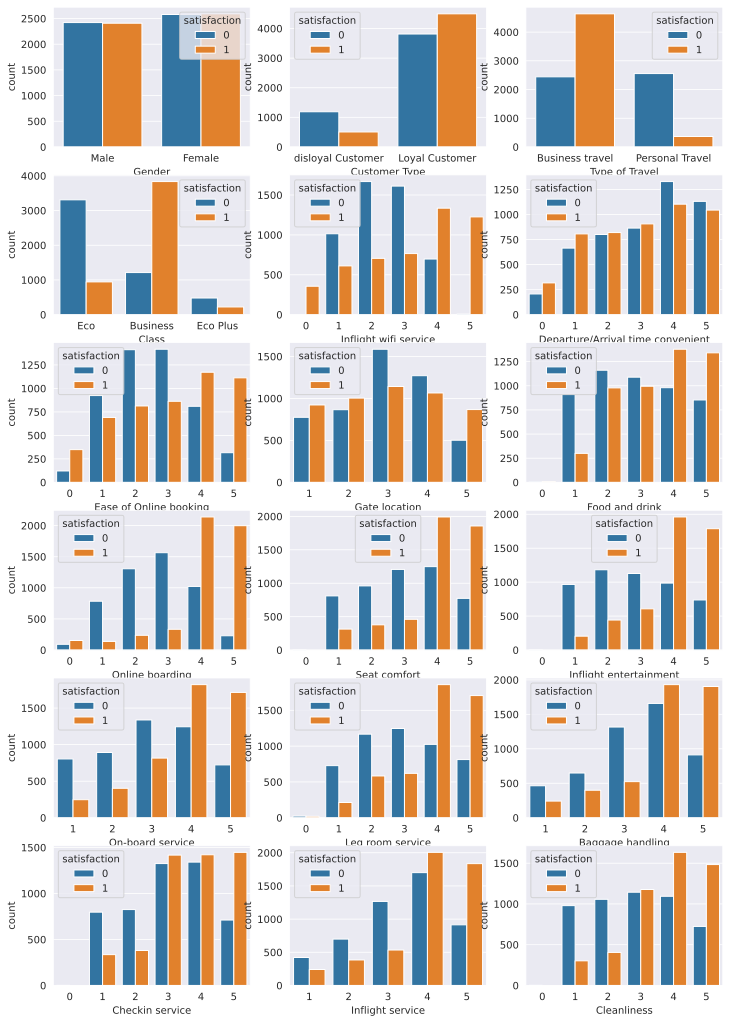

In [ ]:
inds = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2),
        (3,0),(3,1),(3,2),(4,0),(4,1),(4,2),(5,0),(5,1),(5,2)]
fig, ax = plt.subplots(6, 3, figsize=(12, 18))
for col, ind in zip(cat_cols + rat_cols, inds):
    sns.countplot(ax=ax[ind], data=df, x=col, hue='satisfaction')

In [ ]:
num_cols = ['Departure Delay in Minutes', 'Age', 'Flight Distance', 
            'Arrival Delay in Minutes']
df[num_cols].describe()

,Departure Delay in Minutes,Age,Flight Distance,Arrival Delay in Minutes
count,10000.000000,10000.000000,10000.000000,9972.000000
mean,14.429900,39.375100,1229.556200,14.709888
std,39.659674,14.897959,1022.281958,40.046355
min,0.000000,7.000000,31.000000,0.000000
25%,0.000000,27.000000,421.000000,0.000000
50%,0.000000,40.000000,863.500000,0.000000
75%,12.000000,51.000000,1806.750000,12.000000
max,921.000000,80.000000,4983.000000,924.000000


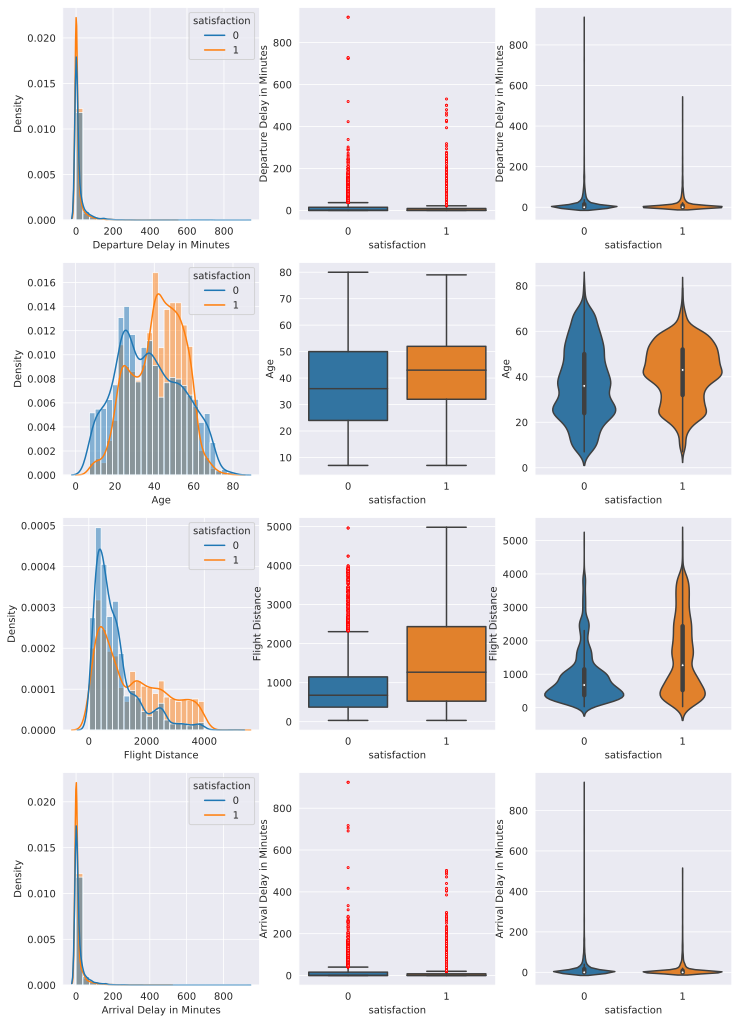

In [ ]:
flierprops = dict(marker='o', markerfacecolor='w', markersize=2,
linestyle='none', markeredgecolor='r')

inds = [[(0,0),(0,1),(0,2)],[(1,0),(1,1),(1,2)],[(2,0),(2,1),(2,2)],
       [(3,0),(3,1),(3,2)]]
fig, ax = plt.subplots(4, 3, figsize=(12, 18))
for col, ind in zip(num_cols, inds):
    sns.histplot(ax=ax[ind[0]],data=df, x=col, hue='satisfaction', bins=25, stat='density')
    sns.kdeplot(ax=ax[ind[0]], data=df, x=col, hue='satisfaction', c='r')
    sns.boxplot(ax=ax[ind[1]], data=df, y=col, x='satisfaction', fliersize=2, flierprops = flierprops)
    sns.violinplot(ax=ax[ind[2]], data=df, y=col, x='satisfaction')

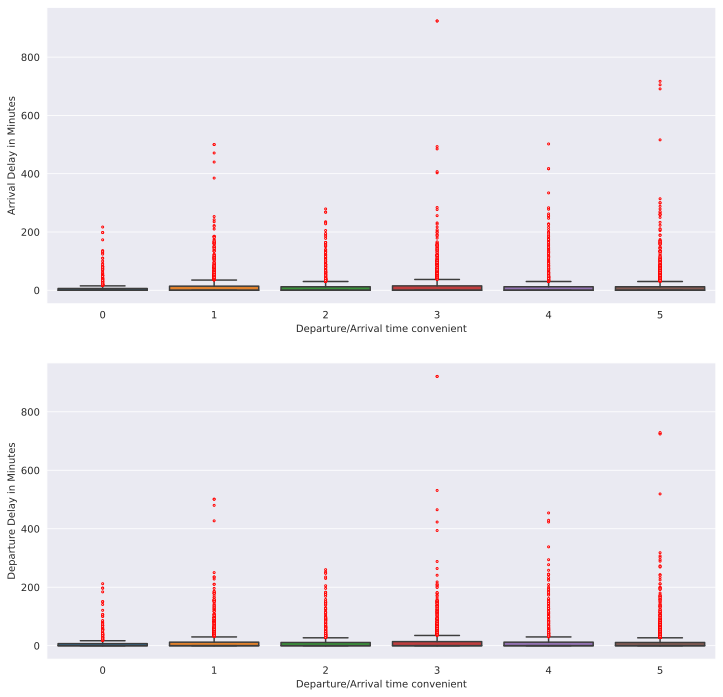

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
sns.boxplot(ax=ax[0], data=df, y='Arrival Delay in Minutes', x='Departure/Arrival time convenient', fliersize=2, flierprops = flierprops)
sns.boxplot(ax=ax[1], data=df, y='Departure Delay in Minutes', x='Departure/Arrival time convenient', fliersize=2, flierprops = flierprops)
plt.show()

Yetib kelgandagi va jo\`nab ketishdagi kechikish vaqtlari yo\`lovchining ushbu ko\`rsatkichlardan qoniqish darajasiga mutanosib emas ekan. Shuningdek parvozdan qanoatlangan va qanoatlanmagan mijozlar uchun kechikish vaqtlari deyarli bir xil. Demak ushbu ko\`rsatkichlarni ham olib tashlasak bo\`ladi.

In [ ]:
drop_features = DropUnnecessaryFeatures(features=['Departure Delay in Minutes', 'Arrival Delay in Minutes'])
drop_features.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,2,4,4,3,1,3,4,3,4,0
1,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,4,5,5,5,5,3,5,3,1
2,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,4,3,1,1,1,1,1,1,2,0
3,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,2,2,4,4,5,5,4,2,1
4,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,3,4,4,5,2,5,3,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,2,...,5,4,4,4,1,4,4,4,3,0
9996,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,1,...,3,3,4,4,4,4,1,4,4,0
9997,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,3,...,4,5,4,4,4,4,3,4,3,1
9998,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,4,...,4,5,3,4,5,5,5,4,5,1


Kategoriyali ustunlardagi qiymatlarni ketma-ket keluvchi sonli qiymatlar bilan almashtiramiz

In [ ]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, features=cat_cols):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                values = X[f].value_counts().index
                labels = pd.Series(range(1, 1+ len(values)), index=values)
                X[f] = X[f].map(lambda c: labels[c])
        return X
encoder = Encoder()
encoder.fit_transform(df)
df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,2,2,33,1,2,571,2,3,2,4,...,2,4,4,3,1,3,4,3,4,0
1,1,1,49,1,1,1431,4,1,4,4,...,5,4,5,5,5,5,3,5,3,1
2,1,1,43,1,2,867,1,4,4,4,...,4,3,1,1,1,1,1,1,2,0
3,1,1,27,1,1,1550,3,3,3,3,...,2,2,2,4,4,5,5,4,2,1
4,2,1,11,2,2,526,3,4,3,2,...,3,4,4,5,2,5,3,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,54,2,2,1068,1,4,1,2,...,5,4,4,4,1,4,4,4,3,0
9996,1,1,54,1,3,1399,4,1,1,1,...,3,3,4,4,4,4,1,4,4,0
9997,2,1,46,1,1,1440,3,3,2,3,...,4,5,4,4,4,4,3,4,3,1
9998,1,1,41,1,1,90,4,1,4,4,...,4,5,3,4,5,5,5,4,5,1


Ishlashda qulay bo\`lishi uchun 0 dan 5 gacha qo\`yilgan baholarning har birini 1 ga orttirib 1 dan 6 gacha baholarga aylantiramiz.

In [ ]:
class ValueChanger(BaseEstimator, TransformerMixin):
    def __init__(self, features=rat_cols):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        for f in self.features:
            X[f] = X[f].map(lambda x: x+1)
        return X
value_changer = ValueChanger()
value_changer.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,2,2,33,1,2,571,3,4,3,5,...,3,5,5,4,2,4,5,4,5,0
1,1,1,49,1,1,1431,5,2,5,5,...,6,5,6,6,6,6,4,6,4,1
2,1,1,43,1,2,867,2,5,5,5,...,5,4,2,2,2,2,2,2,3,0
3,1,1,27,1,1,1550,4,4,4,4,...,3,3,3,5,5,6,6,5,3,1
4,2,1,11,2,2,526,4,5,4,3,...,4,5,5,6,3,6,4,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,54,2,2,1068,2,5,2,3,...,6,5,5,5,2,5,5,5,4,0
9996,1,1,54,1,3,1399,5,2,2,2,...,4,4,5,5,5,5,2,5,5,0
9997,2,1,46,1,1,1440,4,4,3,4,...,5,6,5,5,5,5,4,5,4,1
9998,1,1,41,1,1,90,5,2,5,5,...,5,6,4,5,6,6,6,5,6,1


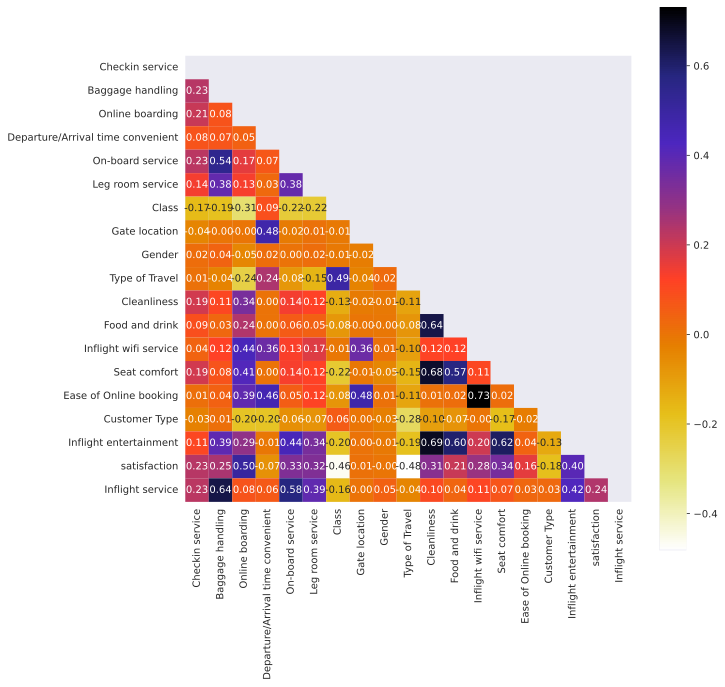

In [ ]:
other_cols = list(set(df.columns) - set(num_cols))
corr_matrix = df[other_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, mask=mask, square=True, annot=True, cmap='CMRmap_r', fmt='.2f')
plt.show()

Erkaklar va ayollar uchun ham parvozdan qoniquvchi va qoniqmaydigan mijozlar soni teng va mijoz bergan baho uning jinsiga deyarli bog\`liq emas ekan. Shuning uchun ham `Gender` ustunini tashlab yuboramiz

In [ ]:
drop_features = DropUnnecessaryFeatures(features=['Gender'])
drop_features.fit_transform(df)

,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,2,33,1,2,571,3,4,3,5,5,3,5,5,4,2,4,5,4,5,0
1,1,49,1,1,1431,5,2,5,5,4,6,5,6,6,6,6,4,6,4,1
2,1,43,1,2,867,2,5,5,5,5,5,4,2,2,2,2,2,2,3,0
3,1,27,1,1,1550,4,4,4,4,3,3,3,3,5,5,6,6,5,3,1
4,1,11,2,2,526,4,5,4,3,5,4,5,5,6,3,6,4,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,54,2,2,1068,2,5,2,3,3,6,5,5,5,2,5,5,5,4,0
9996,1,54,1,3,1399,5,2,2,2,3,4,4,5,5,5,5,2,5,5,0
9997,1,46,1,1,1440,4,4,3,4,4,5,6,5,5,5,5,4,5,4,1
9998,1,41,1,1,90,5,2,5,5,6,5,6,4,5,6,6,6,5,6,1


In [ ]:
class DropUnnecessaryFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features=['id', 'Departure Delay in Minutes',
                                 'Arrival Delay in Minutes', 'Gender']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                X.drop(f, axis=1, inplace=True)
        return X

In [ ]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Type of Travel', 'Customer Type', 'Class']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                values = X[f].value_counts().index
                labels = pd.Series(range(1, 1+ len(values)), index=values)
                X[f] = X[f].map(lambda c: labels[c])
        return X

## Ma\`lumotlarni mashinali o\`rgatish algoritmlari uchun uchun tayyorlash 

In [ ]:
pipeline = Pipeline([
    ('attributeDropper', DropUnnecessaryFeatures()),
    ('fillMissing', FillMissingValues()),
    ('encoder', Encoder()),
    ('valueChanger', ValueChanger())
])

In [ ]:
prepared_to_img = pipeline.fit_transform(data)

In [ ]:
prepared_to_img.to_csv('prepared_to_img.csv', index=False)

Har bir mijozga oid ma\`lumotlardan foydalanib [oddiy rasmlar](https://github.com/eldorjonneymatov/passenger_satisfaction/blob/master/image_generator.py) yaratamiz va ularni **vision learner** yordamida klassifikatsiya qilamiz.

## Modellash 

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install
!git clone https://github.com/eldorjonneymatov/air_passenger_satisfaction/

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Need to get 7,168 kB of archives.
After this operation, 7,962 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.2.0 [7,168 kB]
Fetched 7,168 kB in 1s (11.9 MB/s)
debconf: unable to initializ

In [ ]:
!unzip './air_passenger_satisfaction/images.zip' -d './images'

Streaming output truncated to the last 5000 lines.
  inflating: ./images/images/satisfaction/satis_1.png  
  inflating: ./images/images/satisfaction/satis_10.png  
  inflating: ./images/images/satisfaction/satis_100.png  
  inflating: ./images/images/satisfaction/satis_1000.png  
  inflating: ./images/images/satisfaction/satis_1001.png  
  inflating: ./images/images/satisfaction/satis_1002.png  
  inflating: ./images/images/satisfaction/satis_1003.png  
  inflating: ./images/images/satisfaction/satis_1004.png  
  inflating: ./images/images/satisfaction/satis_1005.png  
  inflating: ./images/images/satisfaction/satis_1006.png  
  inflating: ./images/images/satisfaction/satis_1007.png  
  inflating: ./images/images/satisfaction/satis_1008.png  
  inflating: ./images/images/satisfaction/satis_1009.png  
  inflating: ./images/images/satisfaction/satis_101.png  
  inflating: ./images/images/satisfaction/satis_1010.png  
  inflating: ./images/images/satisfaction/satis_1011.png  
  inflating:

In [ ]:
path = Path('images/images')
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [ ]:
db = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128),
)
dls = db.dataloaders(path, bs=64)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[accuracy])
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.530600,0.356994,0.867000,04:15


epoch,train_loss,valid_loss,accuracy,time
0,0.265715,0.229904,0.905000,04:17
1,0.185885,0.197564,0.916000,04:17
2,0.134846,0.151670,0.939000,04:13
3,0.088329,0.145583,0.943000,04:12


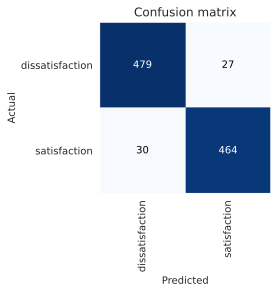

In [ ]:
intrep = ClassificationInterpretation.from_learner(learn)
intrep.plot_confusion_matrix()